<a href="https://colab.research.google.com/github/ngcebohadebe/Insurance-Project/blob/main/project_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy.
#from pycaret.classification import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/Explore Ai/insurance_claims_raw.xlsx'
#df = pd.read_excel(path)
df = pd.read_excel(path)
df.head()


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48.0,521585,2014-10-17,OH,250/500,1000.0,1406.91,0,466132,...,YES,71610.0,6510.0,13020.0,52080,Saab,92x,2004,Y,NaN
1,228,42.0,342868,2006-06-27,IN,250/500,2000.0,1197.22,5000000,468176,...,?,5070.0,780.0,780.0,3510,Mercedes,E400,2007,Y,NaN
2,134,29.0,687698,2000-09-06,OH,100/300,2000.0,1413.14,5000000,430632,...,NO,34650.0,7700.0,3850.0,23100,Dodge,RAM,2007,N,NaN
3,256,41.0,227811,1990-05-25,IL,250/500,2000.0,1415.74,6000000,608117,...,NO,63400.0,6340.0,6340.0,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44.0,367455,2014-06-06,IL,500/1000,1000.0,1583.91,6000000,610706,...,NO,6500.0,1300.0,650.0,4550,Accura,RSX,2009,N,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           1000 non-null   int64         
 1   age                          998 non-null    float64       
 2   policy_number                1000 non-null   int64         
 3   policy_bind_date             1000 non-null   datetime64[ns]
 4   policy_state                 1000 non-null   object        
 5   policy_csl                   1000 non-null   object        
 6   policy_deductable            998 non-null    float64       
 7   policy_annual_premium        997 non-null    float64       
 8   umbrella_limit               1000 non-null   int64         
 9   insured_zip                  1000 non-null   int64         
 10  insured_sex                  1000 non-null   object        
 11  insured_education_level      999 non-null   

In [6]:
df_pro = df[df['insured_occupation']=='prof-specialty']
education_level_mode = df_pro['insured_education_level'].mode()[0]
df['insured_education_level'].fillna(education_level_mode, inplace=True)

In [7]:
df_pro = df[df['insured_occupation']=='prof-specialty']
education_level_mode = df_pro['insured_education_level'].mode()[0]
df['insured_education_level'].fillna(education_level_mode, inplace=True)

In [8]:
df.loc[11, 'incident_state']='Illinois'
df.loc[112, 'incident_state']='Ohio'

In [9]:
df_fem =df[(df['insured_sex']=='FEMALE') & (df['insured_education_level']=='PhD') & (df['insured_occupation'] == 'armed-forces')]
insured_hob_f = df_fem['insured_hobbies'].mode()[0]
df.loc[3, 'insured_hobbies'] = insured_hob_f

df_mal =df[(df['insured_sex']=='MALE') & (df['age']> 40) & (df['insured_education_level']=='Associate') ]
insured_hob_m = df_mal['insured_hobbies'].mode()[0]  # Get the first mode value
df.loc[4, 'insured_hobbies'] = insured_hob_m

In [10]:
df_age_F = df[(df['insured_sex']=='FEMALE') & (df['months_as_customer']> 200)]
age_F = df_age_F['age'].mode()[0]
df.loc[81, 'age'] = age_F

df_age_F_C = df[(df['insured_sex']=='FEMALE') & (df['months_as_customer']> 30)]
age_F_C = df_age_F_C['age'].mode()[0]
df.loc[42, 'age'] = age_F_C

In [11]:
cap_gain_mean = round(df['capital-gains'].mean(),2)

df['capital-gains'].fillna(cap_gain_mean, inplace=True)

In [12]:
df['policy_deductable'].fillna(df['policy_deductable'].mean(), inplace = True)
df['policy_annual_premium'].fillna(df['policy_annual_premium'].mean(), inplace = True)


In [13]:
df['property_claim'] = df['property_claim'].fillna(df['total_claim_amount'] - df['vehicle_claim'] - df['injury_claim'])
df['injury_claim'] = df['injury_claim'].fillna(df['total_claim_amount'] - df['vehicle_claim'] - df['property_claim'])
df['total_claim_amount'] = df['total_claim_amount'].fillna(df['injury_claim'] + df['vehicle_claim'] + df['property_claim'])


In [14]:
df_contacted = df[df['authorities_contacted'].isna()]

In [15]:
df_contacted['incident_severity'].value_counts()

,count
incident_severity,
Minor Damage,50
Trivial Damage,41
Major Damage,1
Total Loss,1


In [16]:
df['authorities_contacted'].fillna('unknown', inplace = True)


In [17]:
df = df.drop('_c39', axis=1)

In [18]:
df_powerbi =df.copy()
df_powerbi.to_csv('df_cleaned.csv', index=False)

In [19]:
def create_time_features(df, time_col_name='time'):
  """
  This function takes a DataFrame and a column name (default 'time') containing
  datetime objects and adds new features including year, month, day, day of week
  (string representation), and hour.

  Args:
      df (pandas.DataFrame): The DataFrame containing the 'time' column.
      time_col_name (str, optional): The name of the column containing datetime data.
          Defaults to 'time'.

  Returns:
      pandas.DataFrame: The modified DataFrame with new time-based features.
  """
  # Convert 'time' column to datetime format (assuming valid datetime strings)
  df[time_col_name] = pd.to_datetime(df[time_col_name])

  year = time_col_name +'_year'
  month = time_col_name +'_month'
  day = time_col_name +'_day'
  day_of_week = time_col_name +'_day_of_week'

  # Extract features from the datetime column
  df[year] = df[time_col_name].dt.year
  df[month] = df[time_col_name].dt.month
  df[day] = df[time_col_name].dt.day
  df[day_of_week] = df[time_col_name].dt.dayofweek

  # Mapping for day of week (Monday=0, Sunday=6)
  day_of_week_mapping = {
      0: 'Monday',
      1: 'Tuesday',
      2: 'Wednesday',
      3: 'Thursday',
      4: 'Friday',
      5: 'Saturday',
      6: 'Sunday'
  }
  df[day_of_week] = df[day_of_week].map(day_of_week_mapping)

  # Mapping for month
  month_mapping = {
      1: 'January',
      2: 'Febuary',
      3: 'March',
      4: 'April',
      5: 'May',
      6: 'June',
      7: 'July',
      8: 'August',
      9: 'September',
      10: 'October',
      11: 'November',
      12: 'December'
  }
  df[month] = df[month].map(month_mapping)

  return df.drop(time_col_name, axis=1)

In [20]:
df =create_time_features(df, time_col_name='policy_bind_date')
df =create_time_features(df, time_col_name='incident_date')


In [21]:
df.head()

,months_as_customer,age,policy_number,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,...,auto_year,fraud_reported,policy_bind_date_year,policy_bind_date_month,policy_bind_date_day,policy_bind_date_day_of_week,incident_date_year,incident_date_month,incident_date_day,incident_date_day_of_week
0,328,48.0,521585,OH,250/500,1000.0,1406.91,0,466132,MALE,...,2004,Y,2014,October,17,Friday,2015,January,25,Sunday
1,228,42.0,342868,IN,250/500,2000.0,1197.22,5000000,468176,MALE,...,2007,Y,2006,June,27,Tuesday,2015,January,21,Wednesday
2,134,29.0,687698,OH,100/300,2000.0,1413.14,5000000,430632,FEMALE,...,2007,N,2000,September,6,Wednesday,2015,Febuary,22,Sunday
3,256,41.0,227811,IL,250/500,2000.0,1415.74,6000000,608117,FEMALE,...,2014,Y,1990,May,25,Friday,2015,January,10,Saturday
4,228,44.0,367455,IL,500/1000,1000.0,1583.91,6000000,610706,MALE,...,2009,N,2014,June,6,Friday,2015,Febuary,17,Tuesday


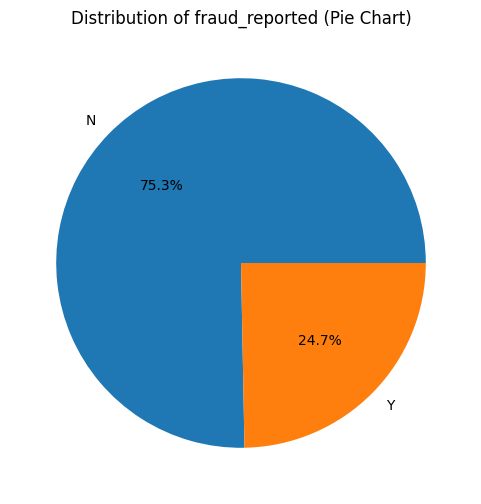

In [22]:
# Create the pie chart
plt.figure(figsize=(6, 6))  # Adjust figure size as needed

# Count occurrences of each category
category_counts = df['fraud_reported'].value_counts()

# Create pie chart slices
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')  # Format percentage labels
plt.title('Distribution of fraud_reported (Pie Chart)')
plt.show()

In [23]:
fraud_binary = {
      'Y': 0, #fraud
      'N': 1  #no fraud
  }

Y= df['fraud_reported'].map(fraud_binary)
X= df.drop('fraud_reported', axis=1)

In [24]:
X = pd.get_dummies(df,dtype=int)
# Again we make sure that all the column names have underscores instead of whitespaces
X.columns = [col.replace(" ","_") for col in X.columns]
X.head()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,...,incident_date_month_Febuary,incident_date_month_January,incident_date_month_March,incident_date_day_of_week_Friday,incident_date_day_of_week_Monday,incident_date_day_of_week_Saturday,incident_date_day_of_week_Sunday,incident_date_day_of_week_Thursday,incident_date_day_of_week_Tuesday,incident_date_day_of_week_Wednesday
0,328,48.0,521585,1000.0,1406.91,0,466132,53300.0,0,5,...,0,1,0,0,0,0,1,0,0,0
1,228,42.0,342868,2000.0,1197.22,5000000,468176,0.0,0,8,...,0,1,0,0,0,0,0,0,0,1
2,134,29.0,687698,2000.0,1413.14,5000000,430632,35100.0,0,7,...,1,0,0,0,0,0,1,0,0,0
3,256,41.0,227811,2000.0,1415.74,6000000,608117,48900.0,-62400,5,...,0,1,0,0,0,1,0,0,0,0
4,228,44.0,367455,1000.0,1583.91,6000000,610706,66000.0,-46000,20,...,1,0,0,0,0,0,0,0,1,0


In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
original_cols = X.columns

# Create a new DataFrame with original column names
#X_scaled_df = pd.DataFrame(columns=original_cols)

# Assign scaled values to DataFrame columns (assuming each column is scaled independently)
X_scaled_df = pd.DataFrame(X_scaled, columns=original_cols)


In [40]:
#y =X_scaled_df['fraud_reported']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, Y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [41]:
X_train

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,...,incident_date_month_Febuary,incident_date_month_January,incident_date_month_March,incident_date_day_of_week_Friday,incident_date_day_of_week_Monday,incident_date_day_of_week_Saturday,incident_date_day_of_week_Sunday,incident_date_day_of_week_Thursday,incident_date_day_of_week_Tuesday,incident_date_day_of_week_Wednesday
633,-0.538470,-1.092893,1.339024,1.418454,0.207891,-0.479476,1.475286,-0.904472,-0.772740,-0.236618,...,-0.945484,0.968496,-0.110208,-0.406818,-0.396746,-0.44614,-0.389966,2.438123,-0.395056,-0.411814
469,-1.468455,-0.435250,1.493740,1.418454,-0.572579,-0.479476,-0.768240,-0.904472,-0.893779,1.634452,...,1.057660,-1.032529,-0.110208,-0.406818,-0.396746,2.24145,-0.389966,-0.410152,-0.395056,-0.411814
815,0.096006,-0.106429,1.117337,-1.039215,0.610023,-0.479476,-0.500078,-0.904472,0.953851,-0.236618,...,1.057660,-1.032529,-0.110208,-0.406818,-0.396746,-0.44614,2.564324,-0.410152,-0.395056,-0.411814
476,-1.190329,-1.092893,0.451545,-0.219992,2.479443,-0.479476,-0.553967,1.265417,-1.459816,0.626952,...,-0.945484,0.968496,-0.110208,-0.406818,-0.396746,-0.44614,-0.389966,2.438123,-0.395056,-0.411814
14,-0.208195,-0.106429,0.380807,1.418454,0.181022,-0.479476,-0.342276,0.579243,-1.021939,0.051239,...,-0.945484,0.968496,-0.110208,-0.406818,-0.396746,-0.44614,-0.389966,2.438123,-0.395056,-0.411814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,-0.833979,-1.092893,-1.201943,-0.219992,0.331939,-0.479476,-0.832734,1.660595,0.953851,-1.100189,...,1.057660,-1.032529,-0.110208,-0.406818,2.520504,-0.44614,-0.389966,-0.410152,-0.395056,-0.411814
169,-1.364158,-0.216036,1.620461,1.418454,-0.061660,-0.479476,-0.992252,1.804296,0.953851,0.914809,...,-0.945484,0.968496,-0.110208,-0.406818,2.520504,-0.44614,-0.389966,-0.410152,-0.395056,-0.411814
474,0.356749,0.332000,-1.275744,-0.219992,1.307507,2.568963,1.577469,-0.904472,-1.498976,1.058738,...,1.057660,-1.032529,-0.110208,2.458100,-0.396746,-0.44614,-0.389966,-0.410152,-0.395056,-0.411814
434,-0.503704,-0.764071,-1.455358,1.418454,0.079700,-0.479476,-0.975870,-0.904472,0.953851,0.051239,...,1.057660,-1.032529,-0.110208,-0.406818,2.520504,-0.44614,-0.389966,-0.410152,-0.395056,-0.411814


### ANN Implementation

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
import datetime

In [43]:
## Build Our ANN Model
model=Sequential([
    Dense(64,activation='relu',input_shape=(X_train.shape[1],)), ## HL1 Connected wwith input layer
    Dense(32,activation='relu'), ## HL2
    Dense(1,activation='sigmoid')  ## output layer
])

In [44]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │          76,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,977 (308.50 KB)

 Trainable params: 78,977 (308.50 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
import tensorflow
opt=tensorflow.keras.optimizers.Adam(learning_rate=0.01)
loss=tensorflow.keras.losses.BinaryCrossentropy()
loss

In [46]:
## compile the model
model.compile(optimizer=opt,loss="binary_crossentropy",metrics=['accuracy'])

In [47]:
## Set up the Tensorboard
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorflow_callback=TensorBoard(log_dir=log_dir,histogram_freq=1)

In [48]:
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)


In [49]:
#X_train= df.drop('fraud_reported', axis=1)

In [50]:
### Train the model
history=model.fit(
    X_train,y_train,validation_data=(X_val,y_val),epochs=100,
    callbacks=[tensorflow_callback,early_stopping_callback]
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7111 - loss: 0.5818 - val_accuracy: 0.9556 - val_loss: 0.1897
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0179 - val_accuracy: 0.9444 - val_loss: 0.1702
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6078e-04 - val_accuracy: 0.9222 - val_loss: 0.2062
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2087e-05 - val_accuracy: 0.9222 - val_loss: 0.2090
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3679e-05 - val_accuracy: 0.9222 - val_loss: 0.2090
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5735e-05 - val_accuracy: 0.9222 - val_loss: 0.2090
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4819e-05 - val_accuracy: 0.9222 - val_loss: 0.2089
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4844e-05 -

In [53]:
print("Evaluate on validation data")
results = model.evaluate(X_val, y_val, batch_size=128)
print("validation loss, test acc:", results)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9444 - loss: 0.1702
test loss, test acc: [0.17021694779396057, 0.9444444179534912]


In [54]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9400 - loss: 0.1496
test loss, test acc: [0.14964346587657928, 0.9399999976158142]
